## Regression model with PyTorch

### Forest Fire dataset. The aim is to predict the burned area based on meteorological conditions and other data.

In [1]:
import numpy as np
import pandas as pd
import torch
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
plt.style.use('seaborn')

In [3]:
datapath = os.path.join(os.getcwd(), 'forestfires.csv')

In [4]:
df = pd.read_csv(datapath)

### Explore the data

In [5]:
# let's inspect the data
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [6]:
df.shape

(517, 13)

The dataframe has 517 rows and 13 columns, 'area' is a target column. Other columns are numerical and categorical.

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


This is a regression task.

In [7]:
df.describe()
# ['FFMC','temp','RH','wind','rain'

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [8]:
# compute correlation 
corr = df.corr()

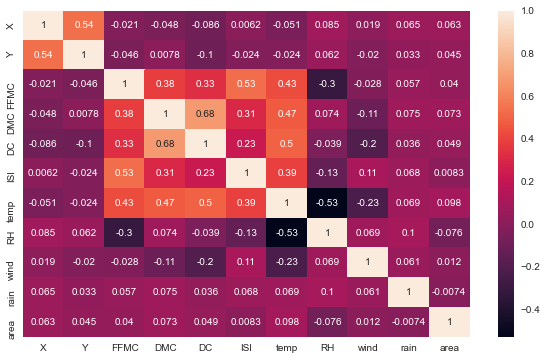

In [9]:
fig, ax = plt.subplots(figsize = (10, 6))

sns.heatmap(corr, annot=True)
plt.show()

'FFMC', 'DMC', 'DC', 'ISI', 'temp' are correlated, but the correlation is not strong.

Let's see correlation between target and feature columns

In [10]:
# compute correlation 
corr_target = df.corr()['area'].sort_values(ascending = False)

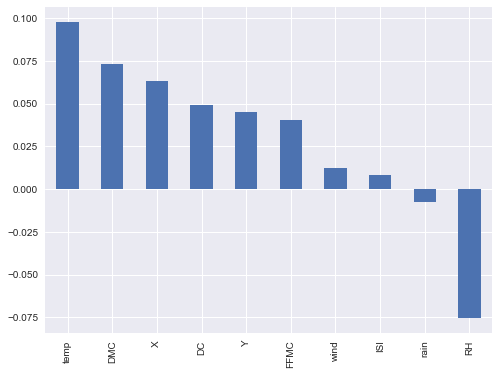

In [11]:
fig, ax = plt.subplots(figsize = (8, 6))
corr_target.drop('area').plot.bar(ax)
plt.show()

RH - relative humidity has negative correlation, it makes sense. The highest positive correlations are with temperature that means the higher the temperature, the more probability for fire to occur.

### Build models

In [12]:
def log_transform(x):
    return np.log(x + 1)

In [13]:
# convert to pytoch dataset
batch_size = 20

def get_dl(inputs, targets, batch_size):
    dataset = TensorDataset(torch.tensor(inputs, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32))

    # we'll split data into train and test using random split 
    train, val = random_split(dataset, [450, 67])

    # create data loaders
    train_dl = DataLoader(train, batch_size = batch_size, shuffle = True)
    val_dl = DataLoader(val, batch_size = batch_size, shuffle = True)
    
    return train_dl, val_dl
    
    

In [14]:
# model 1: not scaled or transformed with area as a target variable. 
# area is very skewed towards 0, it can have a bad impact on the result.
#     features: ['FFMC','temp','RH','wind','rain', 'ISI']
#     target: 'area'

# model 2: same variables with area_log as a target variable
#     features: ['FFMC','temp','RH','wind','rain', 'ISI']
#     target: 'area_log'
        
# model 3: same variables with ISI as a target variable
#     features: ['FFMC','temp','RH','wind','rain', 'area']
#     target: 'ISI'

# model 4: same variables scaled and transformed with ISI as a target variable
#     features: ['FFMC','temp','RH','wind','rain', 'area_log']
#     target: 'ISI'
        

In [15]:
# model 1 data
inputs1 = df[['FFMC','temp','RH','wind','rain', 'ISI']].values
target1 = df['area'].values

train_dl1, val_dl1 = get_dl(inputs1, target1, batch_size=batch_size)

In [16]:
# model 2 data
# We log transform are to get more homogenious values
df['area_log'] = df['area'].apply(lambda x: log_transform(x))

inputs2 = df[['FFMC','temp','RH','wind','rain', 'ISI']].values
target2 = df['area_log'].values

train_dl2, val_dl2 = get_dl(inputs2, target2, batch_size=batch_size)

In [17]:
# model 3 data

inputs3 = df[['FFMC','temp','RH','wind','rain', 'area']].values
target3 = df['ISI'].values

train_dl3, val_dl3 = get_dl(inputs3, target3, batch_size=batch_size)

In [18]:
# model 4 data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df[['FFMC','temp','RH','wind','rain', 'ISI', 'area_log']]),
                         columns = df[['FFMC','temp','RH','wind','rain', 'ISI', 'area_log']].columns)

inputs4 = df_scaled[['FFMC','temp','RH','wind','rain', 'area_log']].values
target4 = df_scaled['ISI'].values

train_dl4, val_dl4 = get_dl(inputs4, target4, batch_size=batch_size)

In [19]:
# input and output sizes are the same for all models. input = 1 and putput = 6.
output_size = 1
input_size = 6

In [20]:
# a basic linear model
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        
        output = self.linear(x)
        return output    

In [21]:
def train_model(model, optimizer, train_dl, epochs):
    history = []
    
    for e in range(epochs):
        print(f'Epoch # %s' %e)
        losses = 0

        for i, (inputs, targets) in enumerate(train_dl):
            print(f'    Batch # %s' %i)

            out = model(inputs).squeeze() #predictions
            loss = F.l1_loss(out, targets) # loss
            loss.backward()
            print('Loss: %s' %loss)
            optimizer.step()
            losses += loss
            optimizer.zero_grad()

        history.append(losses/len(train_dl))
    return history
        
        

In [22]:
def val_model(model, val_dl):
    
    losses = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_dl):
            out = model(inputs).squeeze() #predictions
            loss = F.l1_loss(out, targets) # loss
            losses += loss
    val_loss = losses/len(val_dl)
    
    return val_loss
        
        

In [23]:
def plot_history(history):
    fig, axes = plt.subplots(figsize = (10, 6))
    plt.plot(history, '-x')

    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.title('Training loss')
    plt.show()

In [24]:
model1 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model1.parameters(), lr= 0.001)
history1 = train_model(model1, optimizer, train_dl1, epochs=epochs)

Epoch # 0
    Batch # 0
Loss: tensor(14.3843, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(10.3967, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(4.5729, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(28.2084, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(6.1746, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(10.0215, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(5.4442, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(60.9445, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(12.9084, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(15.3476, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(15.5140, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(9.9458, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(8.6779, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(58.7209, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(8.2876, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(6.0655, grad_fn=<L1LossBackward>)

    Batch # 12
Loss: tensor(10.2090, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(9.8395, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(11.7468, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(6.0546, grad_fn=<L1LossBackward>)
    Batch # 16
Loss: tensor(12.8655, grad_fn=<L1LossBackward>)
    Batch # 17
Loss: tensor(30.7693, grad_fn=<L1LossBackward>)
    Batch # 18
Loss: tensor(8.4792, grad_fn=<L1LossBackward>)
    Batch # 19
Loss: tensor(7.5995, grad_fn=<L1LossBackward>)
    Batch # 20
Loss: tensor(3.9194, grad_fn=<L1LossBackward>)
    Batch # 21
Loss: tensor(17.5953, grad_fn=<L1LossBackward>)
    Batch # 22
Loss: tensor(11.7549, grad_fn=<L1LossBackward>)
Epoch # 8
    Batch # 0
Loss: tensor(4.0014, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(17.7413, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(6.6680, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(1.1546, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(25.2328, grad_fn=<L1LossBackwa

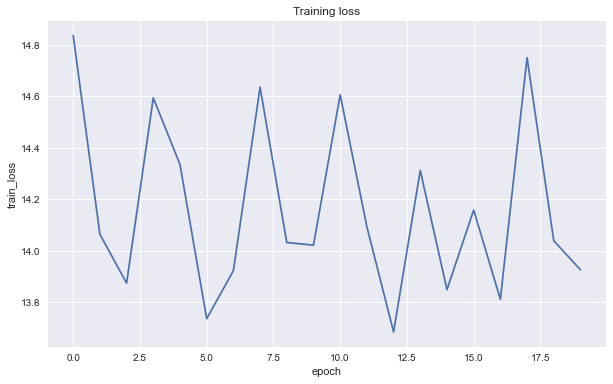

In [25]:
plot_history(history1)

In [26]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl1)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl1)))

Evaluate on training: 14.3214
Evaluate on validation : 11.7549


This model uses all unscaled variables and a traget too skewed to 0. 
Training loss per epoch goes down but has many peaks. The model finds it hard to converge. The same demonstrates the evaluation scores.

In [27]:
model2 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model2.parameters(), lr= 0.001)
history2 = train_model(model2, optimizer, train_dl2, epochs=epochs)


Epoch # 0
    Batch # 0
Loss: tensor(24.4213, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(15.4524, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(4.2859, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(4.3913, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(5.4985, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(5.2515, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(6.9133, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(4.1775, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(5.2702, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(3.2842, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(6.0398, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(4.6580, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(6.0562, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(4.0441, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(6.3287, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(5.8879, grad_fn=<L1LossBackward>)
    Ba

Loss: tensor(4.7202, grad_fn=<L1LossBackward>)
    Batch # 16
Loss: tensor(6.1639, grad_fn=<L1LossBackward>)
    Batch # 17
Loss: tensor(4.0857, grad_fn=<L1LossBackward>)
    Batch # 18
Loss: tensor(5.7855, grad_fn=<L1LossBackward>)
    Batch # 19
Loss: tensor(5.5039, grad_fn=<L1LossBackward>)
    Batch # 20
Loss: tensor(5.5448, grad_fn=<L1LossBackward>)
    Batch # 21
Loss: tensor(5.5760, grad_fn=<L1LossBackward>)
    Batch # 22
Loss: tensor(4.9139, grad_fn=<L1LossBackward>)
Epoch # 15
    Batch # 0
Loss: tensor(5.1874, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(5.6683, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(4.8723, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(6.3864, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(4.7219, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(5.7477, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(5.4498, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(5.9791, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: 

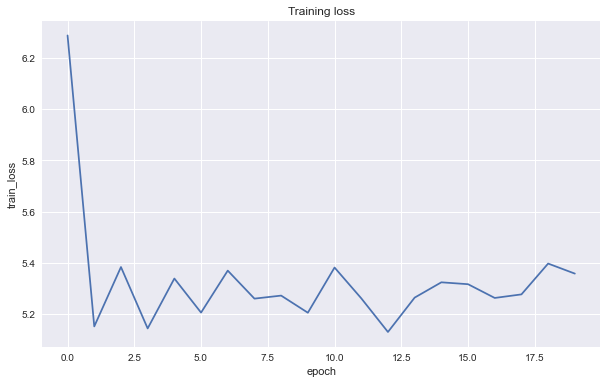

In [28]:
plot_history(history2)

In [29]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl2)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl2)))

Evaluate on training: 4.6644
Evaluate on validation : 4.9077


Second model uses as a target area_log, that is a log transformed area. This may help to get better results. What we see is that the loss drops significantly and then stays on the same levels having peaks up an down.
Transforming the target helped a model to converge faster though still at certain level it is hard for the model to learn.

In [30]:
model3 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model3.parameters(), lr= 0.001)
history3 = train_model(model3, optimizer, train_dl3, epochs=epochs)


Epoch # 0
    Batch # 0
Loss: tensor(10.5397, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(4.2151, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(4.2193, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(5.0488, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(5.3577, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(8.4178, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(4.1723, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(4.1002, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(4.4575, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(3.5977, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(6.2254, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(3.4628, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(6.1342, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(4.5973, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(4.3911, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(5.6924, grad_fn=<L1LossBackward>)
    Bat

    Batch # 6
Loss: tensor(2.3399, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(5.9172, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(4.8248, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(6.6035, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(4.2795, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(3.3322, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(3.2303, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(2.1162, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(3.3903, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(3.0033, grad_fn=<L1LossBackward>)
    Batch # 16
Loss: tensor(3.6549, grad_fn=<L1LossBackward>)
    Batch # 17
Loss: tensor(3.9193, grad_fn=<L1LossBackward>)
    Batch # 18
Loss: tensor(4.1094, grad_fn=<L1LossBackward>)
    Batch # 19
Loss: tensor(6.6595, grad_fn=<L1LossBackward>)
    Batch # 20
Loss: tensor(5.4266, grad_fn=<L1LossBackward>)
    Batch # 21
Loss: tensor(5.4172, grad_fn=<L1LossBackward>)
    Batch # 

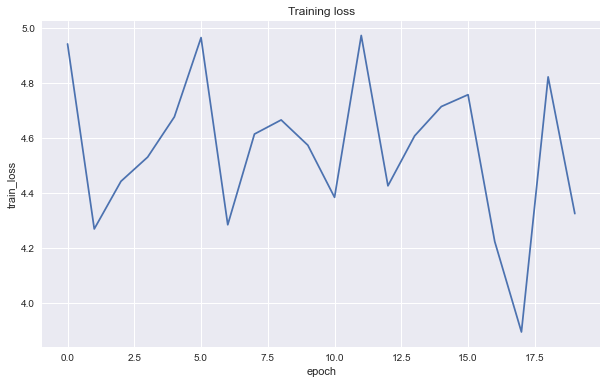

In [31]:
plot_history(history3)

In [32]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl3)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl3)))

Evaluate on training: 3.9189
Evaluate on validation : 4.3289


The model number 3 uses unscaled features and target. Target in this case is ISI: Initial Spread Index that indicates  estimate a fire spread potential.
Training losses decrease drastically during the first epochs, then the loss goes up and down. If the learning rate is bigger, the model finds it more difficult to learn.

In [33]:
model4 = Linear()
epochs = 20
optimizer = torch.optim.SGD(model4.parameters(), lr= 0.01)
history4 = train_model(model4, optimizer, train_dl4, epochs=epochs)


Epoch # 0
    Batch # 0
Loss: tensor(0.5674, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(0.9536, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(0.8935, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(1.0540, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(0.6599, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(1.0245, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(0.8115, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(0.6182, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(0.6377, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(1.0468, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(0.4691, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(0.5812, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(0.9990, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(0.8871, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(1.1558, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(1.0544, grad_fn=<L1LossBackward>)
    Batc

    Batch # 19
Loss: tensor(0.6784, grad_fn=<L1LossBackward>)
    Batch # 20
Loss: tensor(0.4277, grad_fn=<L1LossBackward>)
    Batch # 21
Loss: tensor(0.5662, grad_fn=<L1LossBackward>)
    Batch # 22
Loss: tensor(0.7286, grad_fn=<L1LossBackward>)
Epoch # 6
    Batch # 0
Loss: tensor(0.6249, grad_fn=<L1LossBackward>)
    Batch # 1
Loss: tensor(0.5726, grad_fn=<L1LossBackward>)
    Batch # 2
Loss: tensor(0.5172, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(0.5078, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(0.3402, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(0.3900, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(0.5281, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(0.6868, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(0.5485, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(0.4248, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(0.5356, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(0.3334, grad_fn=<L1LossBackward>)
    Batc

Loss: tensor(0.6414, grad_fn=<L1LossBackward>)
    Batch # 3
Loss: tensor(0.3200, grad_fn=<L1LossBackward>)
    Batch # 4
Loss: tensor(1.0511, grad_fn=<L1LossBackward>)
    Batch # 5
Loss: tensor(0.5115, grad_fn=<L1LossBackward>)
    Batch # 6
Loss: tensor(0.3276, grad_fn=<L1LossBackward>)
    Batch # 7
Loss: tensor(0.6676, grad_fn=<L1LossBackward>)
    Batch # 8
Loss: tensor(0.4469, grad_fn=<L1LossBackward>)
    Batch # 9
Loss: tensor(0.4137, grad_fn=<L1LossBackward>)
    Batch # 10
Loss: tensor(0.4630, grad_fn=<L1LossBackward>)
    Batch # 11
Loss: tensor(0.4957, grad_fn=<L1LossBackward>)
    Batch # 12
Loss: tensor(0.5476, grad_fn=<L1LossBackward>)
    Batch # 13
Loss: tensor(0.5712, grad_fn=<L1LossBackward>)
    Batch # 14
Loss: tensor(0.3232, grad_fn=<L1LossBackward>)
    Batch # 15
Loss: tensor(0.3601, grad_fn=<L1LossBackward>)
    Batch # 16
Loss: tensor(0.4945, grad_fn=<L1LossBackward>)
    Batch # 17
Loss: tensor(0.6524, grad_fn=<L1LossBackward>)
    Batch # 18
Loss: tensor(0.

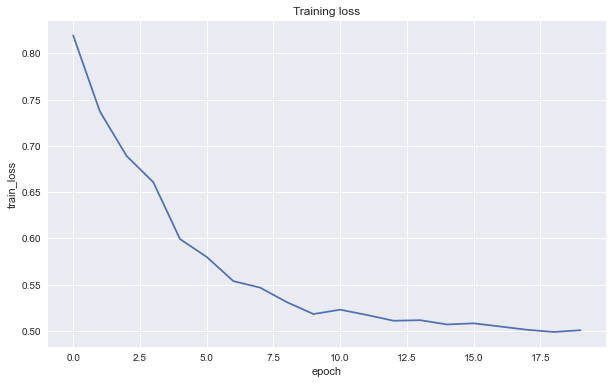

In [34]:
plot_history(history4)

In [35]:
print('Evaluate on training: {:.4f}'.format(val_model(model1, train_dl4)))
print('Evaluate on validation : {:.4f}'.format(val_model(model1, val_dl4)))

Evaluate on training: 0.7495
Evaluate on validation : 0.5781


The model 4 uses scaled features and target 'ISI' for training. The loss goes down steadily and shows the better results.
We can't compare the models by it loss values because we used scaled and unscaled values. But looking at the graph we can say it is the most stable model.

Comparing these 4 models we conclude that features scaling is essential for training a good ML model.